In [23]:
import torch
import torch.nn as nn
import math
import numpy as np
from interface_pde import BasePDE

from utils_uq_vi import VIBPINN
from utils_pde_damposcillation import DampedOscillator1D
from utils_pde_poisson import Poisson1D
from utils_result_viz import * # plot_truth_and_samples_1D, plot_training_history

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon GPU (M1/M2/M3)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
else:
    device = torch.device("cpu")   # Fallback to CPU

device = torch.device("cpu")
torch.set_default_device(device)
print(f"Using device: {device}")

Using device: cpu


In [24]:
# Example: 1D Poisson equation, u''(x) = f(x) on [0,1], with u(0)=0, u(1)=0.
# Define f(x) (source term). For example, f(x) = -π^2 * sin(πx) has true solution u(x)=sin(πx) on [0,1] with zero boundary.
omega_true = 2*np.pi    # undamped frequency
zeta_true  = 0.1       # damping ratio
A   = 0.5          # new amplitude
phi = 1.2          # new phase in radians
omega_d = omega_true*np.sqrt(1-zeta_true**2)


# Define initial condition
t0 = torch.zeros((1, 1), device=device, dtype=torch.float32)  # no grads needed
x0_val = A * math.cos(phi)                     # scalar Python float
v0_val = -A * zeta_true * omega_true * math.cos(phi)  \
        - A * omega_d      * math.sin(phi)
x0 = torch.tensor([[x0_val ]], device=device, dtype=torch.float32)
v0 = torch.tensor([[v0_val]], device=device, dtype=torch.float32)

In [25]:
# Analytical solution function
def x_true(t):
    # Underdamped solution: A*exp(-zeta*omega*t) * cos(omega_d*t + phi)
    return A * np.exp(-zeta_true*omega_true*t) * np.cos(omega_d*t + phi)


# Define source function: f(x) = -π² sin(πx)
def f_func(x):
    return 0

In [26]:
data_noise = 0.05

pde = DampedOscillator1D(
    zeta_true,
    omega_true, 
    f_func, 
    (x0, v0),
    (0, 5),
    x_true)

# Generate training and testing data of the poisson function
(X_train, Y_train) = pde.data_generation(300, data_noise)
(X_test, Y_test) = pde.data_generation(100, data_noise)
(X_calibration, Y_calibration) = pde.data_generation(100, data_noise)

# Collocation points in (0,5)
x_colloc_num = 300
x_collocation = torch.linspace(0.0, 5.0, steps=x_colloc_num).view(-1, 1)
x_collocation = x_collocation[(x_collocation > 0) & (x_collocation < 5)].view(-1, 1)

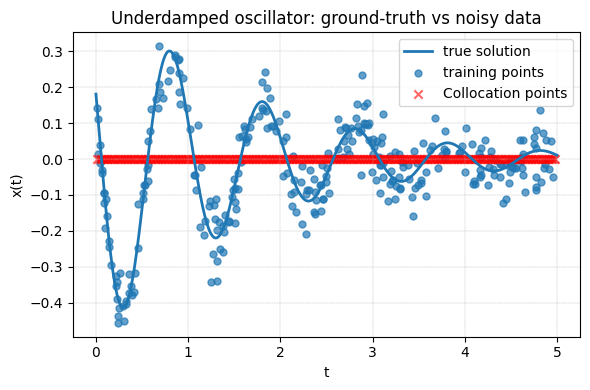

In [27]:
fig, ax = plot_truth_and_samples_1D(
    x0     = 0,
    x1     = 5,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=x_true,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

In [28]:
# from draft import VIBPINN
from utils_uq_cp import CPPINN
cp_poisson_model = CPPINN(pde, 1, [16, 32, 64, 128, 128, 64, 32, 16], 1)
loss_dict = cp_poisson_model.fit_cp_pinn(x_colloc_num, X_train=X_train, Y_train=Y_train, epochs=40000, lr=3e-3,
                               λ_pde=5.0,λ_ic=5.0)

ep     1 | L=5.97e+01 | data=2.03e-02 | pde=2.70e+00  ic=9.21e+00  bc=0.00e+00 | lr=3.00e-03
ep   500 | L=1.88e+01 | data=1.54e-02 | pde=2.94e+00  ic=8.17e-01  bc=0.00e+00 | lr=3.00e-03
ep  1000 | L=8.74e+00 | data=1.18e-02 | pde=1.35e+00  ic=3.84e-01  bc=0.00e+00 | lr=3.00e-03
ep  1500 | L=7.15e+00 | data=1.05e-02 | pde=1.19e+00  ic=2.28e-01  bc=0.00e+00 | lr=3.00e-03
ep  2000 | L=5.16e+00 | data=8.98e-03 | pde=9.24e-01  ic=9.99e-02  bc=0.00e+00 | lr=3.00e-03
ep  2500 | L=2.22e+00 | data=6.32e-03 | pde=3.88e-01  ic=5.01e-02  bc=0.00e+00 | lr=3.00e-03
ep  3000 | L=1.11e+00 | data=4.60e-03 | pde=2.09e-01  ic=7.48e-03  bc=0.00e+00 | lr=3.00e-03
ep  3500 | L=9.57e-01 | data=4.38e-03 | pde=1.79e-01  ic=8.34e-03  bc=0.00e+00 | lr=3.00e-03
ep  4000 | L=1.33e+00 | data=4.32e-03 | pde=2.46e-01  ic=1.59e-02  bc=0.00e+00 | lr=3.00e-03
ep  4500 | L=5.22e-01 | data=3.43e-03 | pde=9.86e-02  ic=2.38e-03  bc=0.00e+00 | lr=3.00e-03
ep  5000 | L=5.47e-01 | data=3.21e-03 | pde=1.05e-01  ic=9.24e-04  bc=

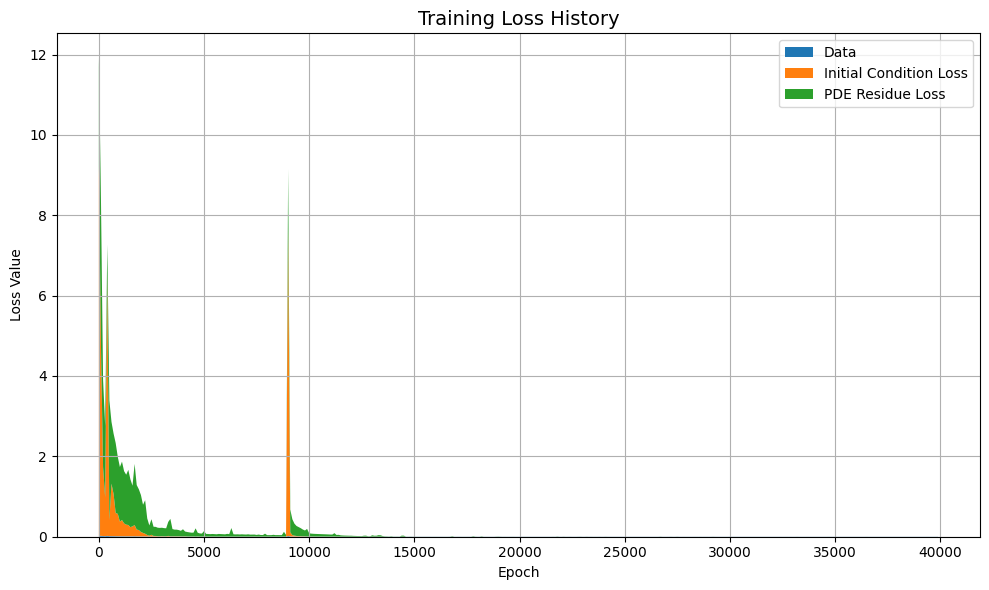

In [29]:
plot_training_history(loss_dict, plot_after=0, step=100)

## Prediction

In [30]:
distance_space = "feature"
neighbour_size = 20
alpha = 0.05

x_grid = torch.linspace(0, 5, 100).view(-1, 1)
pred_set = cp_poisson_model.predict(alpha, neighbour_size, 
                                    x_grid, X_calibration, Y_calibration, X_train, 
                                    distance_space)

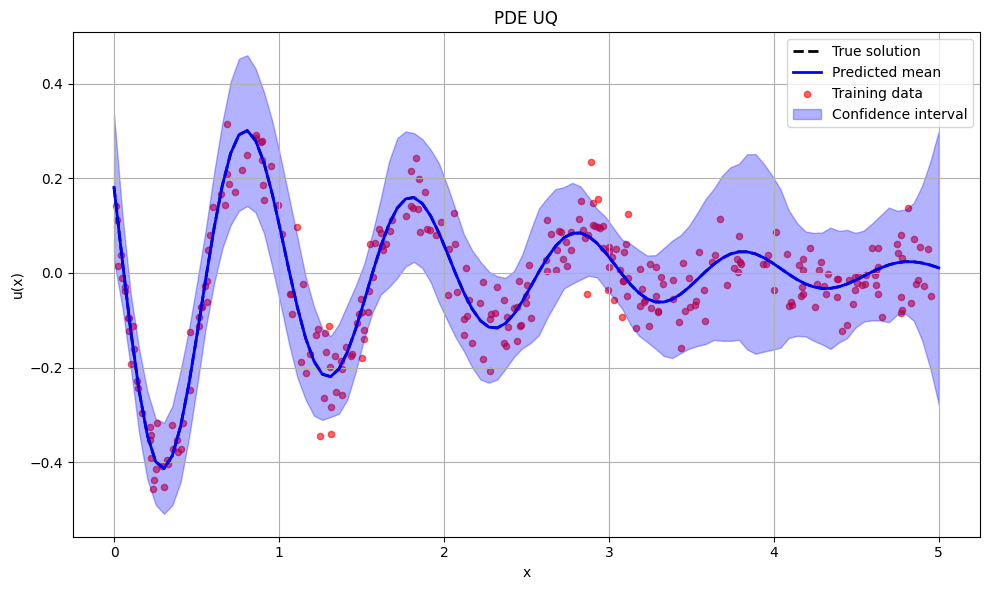

In [31]:
plot_predictions_1D(x_grid, pred_set, x_true, X=X_train, Y=Y_train)

## Sharpness & Coverage

In [34]:
from utils_result_metrics import cp_test_uncertainties
def generating_alphas(a_num):
    alphas = torch.linspace(0.0, 1.0, 10).view(-1, 1)
    return alphas[1:a_num-1]

alphas = generating_alphas(10)

rslt = cp_test_uncertainties(cp_poisson_model, alphas, X_test, Y_test, X_calibration, Y_calibration, X_train, distance_space, neighbour_size)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 204.82it/s]


## Uncertainty Plot


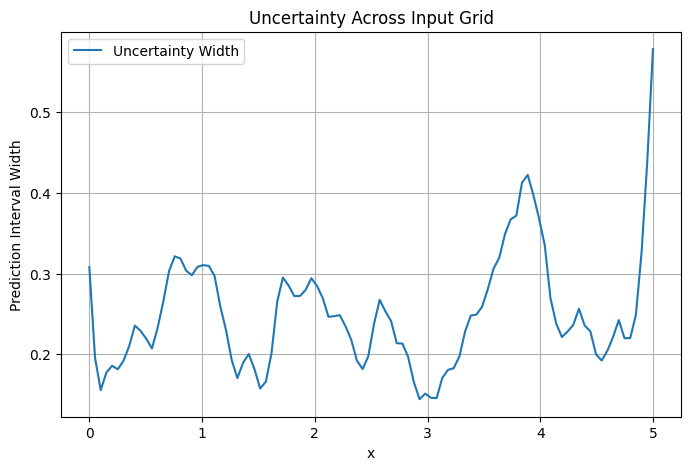

In [35]:
from utils_result_metrics import plot_uncertainty
plot_uncertainty(pred_set, x_grid)